In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model
import matplotlib.ticker as ticker

In [73]:
# Functions

def line(x, m, b):
    return x * m + b

def tlm(s, r_s, N, w, L, r_c):
    return ((r_s * s) / (2 * N * (w + L + s) - L - s)) + (2 * r_c)

def tlm2(s, r_s, N, w, L, l_t):
    return (r_s / (2 * N * (w + L + s) - L - s)) * (s + 2 * l_t)

def w_contact(s, N, w, L):
    return (2 * N * (w + L + s)) - L - s

In [74]:
# Models

line_mod = Model(line)
line_params = line_mod.make_params(m = 1, b = 1)

# Considering L_t to get \rho_c Contact Resistivity
tlm_mod2 = Model(tlm2)
tlm2_params = tlm_mod2.make_params()
tlm2_params['r_s'].set(value = 1e6)
tlm2_params['N'].set(value = 60, vary = False)
tlm2_params['w'].set(value = 5e-4, vary = False)
tlm2_params['L'].set(value = 3200e-4, vary = False)
tlm2_params['l_t'].set(value = 1e-5, min = 0)

In [75]:
# Settings

col = ['Potential (V)', 'Current (A)', 'Time (s)']
col2 = ['Structure', 'Spacing (cm)', 'Resistance ($\Omega$)']
idea2 = {'P01': 2e-4,
         'P02': 5e-4,
         'P03': 10e-4,
         'P04' : 20e-4
         }

formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x / 1e6))
formatter_1 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e4))

sns.set_palette('BuPu_r')

[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 285
    # data points      = 4
    # variables        = 2
    chi-square         = 1.5762e+10
    reduced chi-square = 7.8808e+09
    Akaike info crit   = 92.3782147
    Bayesian info crit = 91.1508034
    R-squared          = 0.99986587
[[Variables]]
    r_s:  3.0471e+11 +/- 2.4880e+09 (0.82%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  2.1330e-05 +/- 4.8242e-06 (22.62%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.816
Contact Resistivity = 139.0304339654296 Ohm cm2
LMO conductivity = 9.533223216639924e-09


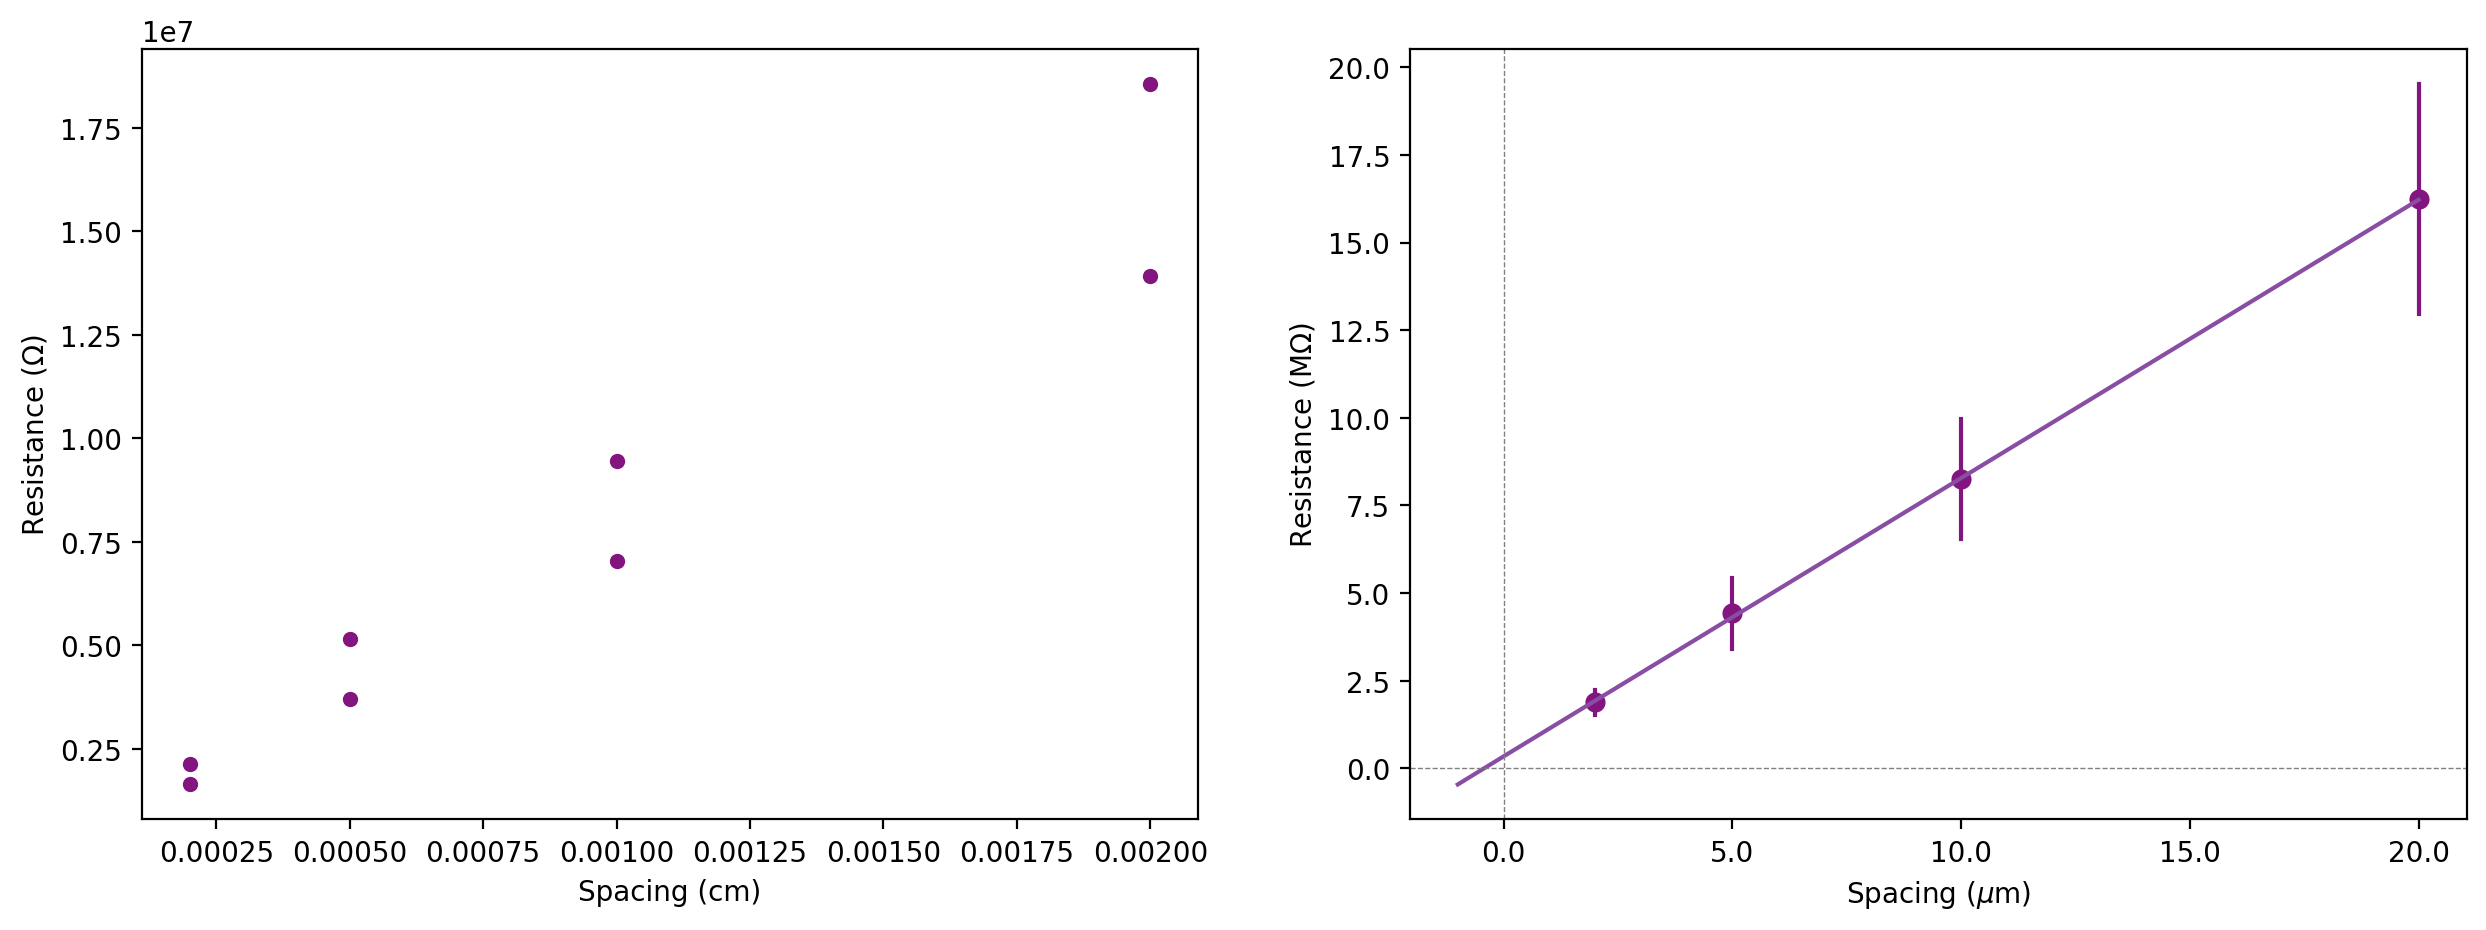

In [80]:
# Function to process data

def C_R(path, sample):
    
    files = [os.path.join(path, i) for i in os.listdir(path)]
    iv_val = pd.DataFrame(columns = col2)
    
    n = 0
    for i in files:
        directory, filename = os.path.split(i)
        df = pd.read_csv(i, sep = ';', skiprows = 1, names = col)
        line_fit = line_mod.fit(df[col[1]], line_params, x = df[col[0]])
        resistance = 1 / line_fit.values['m']
        
        for j in idea2.keys():
            if j in filename:
                iv_val.loc[n] = (j, idea2[j], resistance)
        n += 1

    iv_val['Sample'] = sample
    
    width_ = (w_contact(iv_val[col2[1]], 60, 5e-4, 3200e-4))
    width_avg = width_.mean()

    all_avg = pd.DataFrame()
    u_s = iv_val.Structure.unique()
    df_dict = {i : pd.DataFrame() for i in u_s}
    for key in df_dict.keys():
        df_dict[key] = iv_val[:][iv_val.Structure == key]
    for key, df in df_dict.items():
        mean_ = df.mean(numeric_only = True).reset_index().transpose()
        mean_.columns = mean_.iloc[0]
        mean_ = mean_[1:].reset_index(drop=True)
        all_avg = pd.concat([all_avg, mean_], ignore_index = True)
    
    
    tlm_fit2 = tlm_mod2.fit(all_avg[col2[2]], tlm2_params, s = all_avg[col2[1]])   
    # using the average for the fit. Same values, lower numerical error 
    # tlm_fit2 = tlm_mod2.fit(iv_val[col2[2]], tlm2_params, s = iv_val[col2[1]])
    
    print(tlm_fit2.fit_report())
    rc = tlm_mod2.eval(tlm_fit2.params, s = 0) / 2
    lt = tlm_fit2.values['l_t']
    p_c = rc * lt * width_avg #Contact resistiviy ohm * cm^2
    sigma = (1 / tlm_fit2.values['r_s'] ) / (90e-7 * width_avg)

    print('Contact Resistivity = ' + str(p_c) + ' Ohm cm2')
    print('LMO conductivity = ' + str(sigma))
    
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 200) #    1, 2, figsize = (15,5),
    
    cross_zero = np.array([-1, 0, 20]) * 1e-4
    y_zero = tlm_mod2.eval(tlm_fit2.params, s = cross_zero)
    
    sns.lineplot(data = iv_val, x = col2[1], y = col2[2], marker='o', markersize = 8, errorbar='sd',err_style='bars', linestyle='')
    sns.lineplot(x = cross_zero, y = y_zero)
    
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal zero line
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Vertical zero line
    
    ax[1].set_xlabel('Spacing ($\mu$m)')
    ax[1].set_ylabel('Resistance (M$\Omega$)')
    ax[1].yaxis.set_major_formatter(formatter)
    ax[1].xaxis.set_major_formatter(formatter_1)
    #
    sns.scatterplot(data = iv_val, x = col2[1], y = col2[2], ax = ax[0])
    
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO_Pt'
sample = 'Pt on LMO'

C_R(path, sample)

In [77]:

    # # Plot
    # sns.scatterplot(data = iv_val, x = col2[1], y = col2[2])
    # plt.plot(iv_val[col2[1]], tlm_fit.best_fit)

    # tlm_fit2 = tlm_mod2.fit(iv_val[col2[2]], tlm2_params, s = iv_val[col2[1]])
    # # print(tlm_fit2.fit_report())
    # rc = tlm_mod2.eval(tlm_fit2.params, s = 0) / 2
    # lt = tlm_fit2.values['l_t']
    # p_c = rc * lt * width_avg #Contact resistiviy ohm * cm^2
    
    # # Average
    
    # val_avg = pd.DataFrame()
    # u_s = iv_val.Structure.unique()
    # df_dict = {i : pd.DataFrame() for i in u_s}
    # for key in df_dict.keys():
    #     df_dict[key] = iv_val[:][iv_val.Structure == key]
    # for key, df in df_dict.items():
    #     mean_ = df.mean(numeric_only = True).reset_index().transpose()
    #     mean_.columns = mean_.iloc[0]
    #     mean_ = mean_[1:].reset_index(drop=True)
    #     val_avg = pd.concat([val_avg, mean_], ignore_index = True)  
    
    # ##############
    
    # tlm_fit_avg = tlm_mod2.fit(val_avg[col2[2]], tlm2_params, s = val_avg[col2[1]])
    # print(tlm_fit_avg.fit_report())
    # rc2 = tlm_mod2.eval(tlm_fit_avg.params, s = 0) / 2
    # lt2 = tlm_fit_avg.values['l_t']
    # p_c2 = rc2 * lt2 * width_avg #Contact resistiviy ohm * cm^2
    
    
    # ############## Fit with weights
    # tlm_fit_w = tlm_mod2.fit(iv_val[col2[2]], tlm2_params, s = iv_val[col2[1]], weights = weights)
    # print(tlm_fit_w.fit_report())
    # rc3 = tlm_mod2.eval(tlm_fit_w.params, s = 0) / 2
    # lt3 = tlm_fit_w.values['l_t']
    # p_c3 = rc3 * lt3 * width_avg #Contact resistiviy ohm * cm^2
    
    
    
    # # Plot
    # fig, ax = plt.subplots( figsize = (8, 5), dpi = 100)
    # sns.scatterplot(data = iv_val, x = col2[1], y = col2[2], label = 'Data')
    # ax.plot(iv_val[col2[1]], tlm_fit2.best_fit, 'tab:orange', label = 'Fit')
    # ax.plot(iv_val[col2[1]], tlm_fit_w.best_fit, 'tab:green', label = 'Fit w')
    
    # fig, ax = plt.subplots( figsize = (8, 5), dpi = 100)
    # sns.scatterplot(data = val_avg, x = col2[1], y = col2[2], label = 'Data avg')
    # ax.plot(val_avg[col2[1]], tlm_fit_avg.best_fit, 'tab:orange', label = 'Fit')
    # sns.lineplot(data = iv_val, x = col2[1], y = col2[2], marker='', errorbar='sd',err_style='bars', linestyle='')
    
    # # # plt.legend()
    # # # print(width_)
    # print('Contact Resistivity = ' + str(p_c) + ' Ohm cm2')
    # print('Contact Resistivity2 = ' + str(p_c2) + ' Ohm cm2')
    # print('Contact Resistivity3 w = ' + str(p_c3) + ' Ohm cm2')
    # print('LMO 1 / sheet resistance = ' + str(1/tlm_fit2.values['r_s']))
    # print('LMO 1 / sheet resistance2 = ' + str(1/tlm_fit_avg.values['r_s']))
    # print('LMO 1 / sheet resistance3 w = ' + str(1/tlm_fit_w.values['r_s']))
    
    # result = [iv_val, val_avg]
    # return result